In [1]:
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa

# Import Cell Agent and OrthogonalMooreGrid
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [a for a in self.cell.agents if a is not self]

        if len(cellmates) > 0 and self.wealth > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), torus=True, random=self.random)
        # Instantiate DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"},
        )
        self.running = True

        # Create agents
        agents = MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

    def step(self):
        # Collect data each step
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [3]:
params = {"width": 10, "height": 10, "n": range(5, 105, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
results_df = pd.DataFrame(results)
print(f"The results have {len(results)} rows.")
print(f"The columns of the data frame are {list(results_df.keys())}.")

The results have 525100 rows.
The columns of the data frame are ['RunId', 'iteration', 'Step', 'width', 'height', 'n', 'Gini', 'AgentID', 'Wealth', 'Steps_not_given'].


In [5]:
params = {"seed": None, "width": 10, "height": 10, "n": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=25,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,  # Need to collect every step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

  0%|          | 0/125 [00:00<?, ?it/s]

In [6]:
# The Gini coefficient will be the same for the entire population at any time.
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 1)]
results_5s_df_filtered.head(3)

,RunId,iteration,Step,seed,width,height,n,Gini,AgentID,Wealth,Steps_not_given
1,0,0,1,None,10,10,5,0.0,1.0,1.0,0.0
6,0,0,2,None,10,10,5,0.0,1.0,1.0,1.0
11,0,0,3,None,10,10,5,0.0,1.0,1.0,2.0


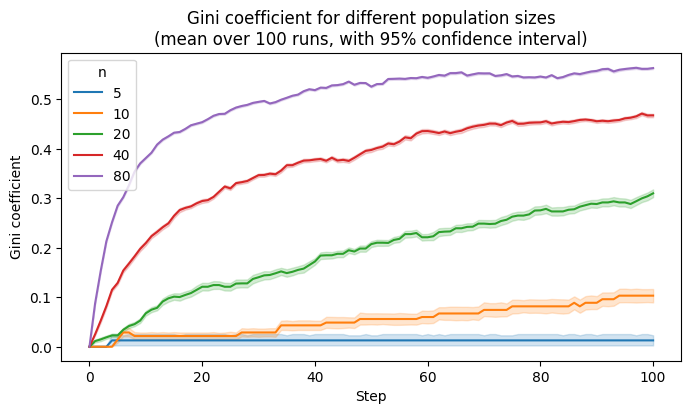

In [7]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="n",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plot_title = (
    "Gini coefficient for different population sizes\n"
    "(mean over 100 runs, with 95% confidence interval)"
)
g.set(title=plot_title, ylabel="Gini coefficient");

In [8]:
# Calculate the mean of the wealth and the number of consecutive rounds
# for all agents in each episode.
agg_results_df = (
    results_5s_df.groupby(["iteration", "n", "Step"])
    .agg({"Wealth": "mean", "Steps_not_given": "mean"})
    .reset_index()
)
agg_results_df.head(3)

,iteration,n,Step,Wealth,Steps_not_given
0,0,5,0,NaN,NaN
1,0,5,1,1.0,0.0
2,0,5,2,1.0,1.0


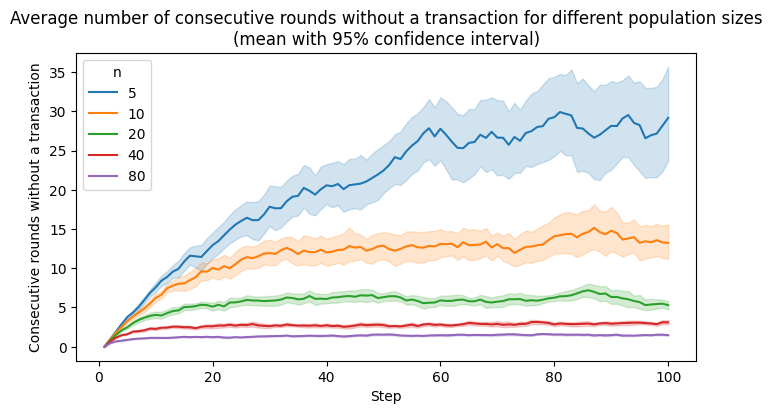

In [9]:
# Create a line plot with error bars
g = sns.lineplot(
    data=agg_results_df, x="Step", y="Steps_not_given", hue="n", palette="tab10"
)
g.figure.set_size_inches(8, 4)
g.set(
    title="Average number of consecutive rounds without a transaction for "
    "different population sizes\n(mean with 95% confidence interval)",
    ylabel="Consecutive rounds without a transaction",
);